In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score

import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D

from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Loading Dataset

In [ ]:
dt = pd.read_csv("/content/drive/MyDrive/NLP/Movie review Analysis/Train Data.csv")

##Analyzing dataset

In [ ]:
dt.head()

,review,sentiment
0,"I'm afraid this one is pretty dreadful, despit...",negative
1,Okay so i found out about this movie and I wat...,negative
2,"Weak plot, predictable violence, only semi int...",negative
3,The dazzling seventeen-minute dance sequence o...,positive
4,.... this movie basks too much in its own inno...,negative


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
dt.describe()

,review,sentiment
count,25000,25000
unique,24904,2
top,This show comes up with interesting locations ...,negative
freq,3,12500


In [ ]:
dt.sample(7)

,review,sentiment
1278,This is a kind of movie that will stay with yo...,positive
8244,I couldn't hold back the tears when I watched ...,positive
8518,Opening credits: great. Music: just right for ...,positive
23202,Featured in 1955's THE COBWEB is an all star c...,negative
24913,This grainy film has a cult following and one ...,negative
23793,***SPOILERS*** ***SPOILERS*** This is without ...,positive
13550,Show favorites Green Arrow (introduced this se...,positive


In [ ]:
dt.isnull().sum()

review       0
sentiment    0
dtype: int64

##EDA

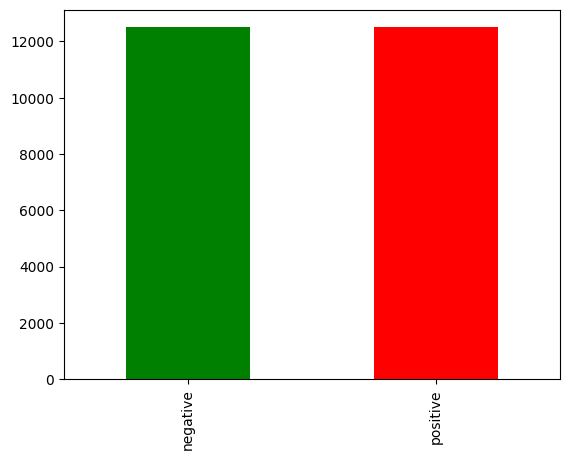

In [ ]:
# Bar Chart
colors = [ 'green', 'red']  # Specify your colors here
sentiment_counts = dt['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=colors)
plt.show()


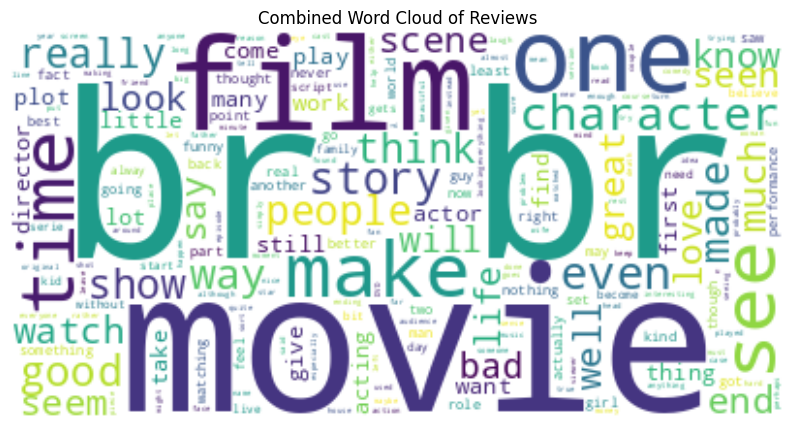

In [ ]:
# Word Clouds
combined_text = " ".join(review for review in dt.review)
wordcloud_all = WordCloud(background_color="white").generate(combined_text)

# Set the figure size
plt.figure(figsize=(10, 6))

# Generate the word cloud
plt.imshow(wordcloud_all, interpolation='bilinear')

# Add a title
plt.title("Combined Word Cloud of Reviews")

# Hide the axis
plt.axis("off")

# Display the plot
plt.show()

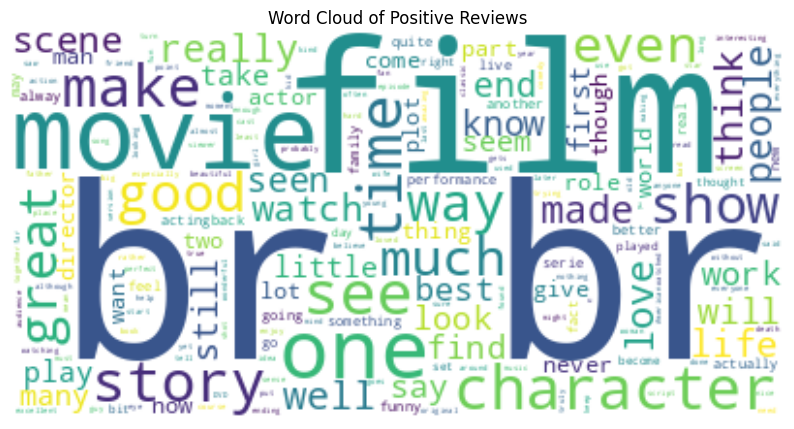

In [ ]:
positive_text = " ".join(review for review in dt[dt["sentiment"]=="positive"].review)
wordcloud_pos = WordCloud(background_color="white").generate(positive_text)

# Set the figure size
plt.figure(figsize=(10, 6))

# Generate the word cloud
plt.imshow(wordcloud_pos, interpolation='bilinear')

# Add a title
plt.title("Word Cloud of Positive Reviews")

# Hide the axis
plt.axis("off")

# Display the plot
plt.show()

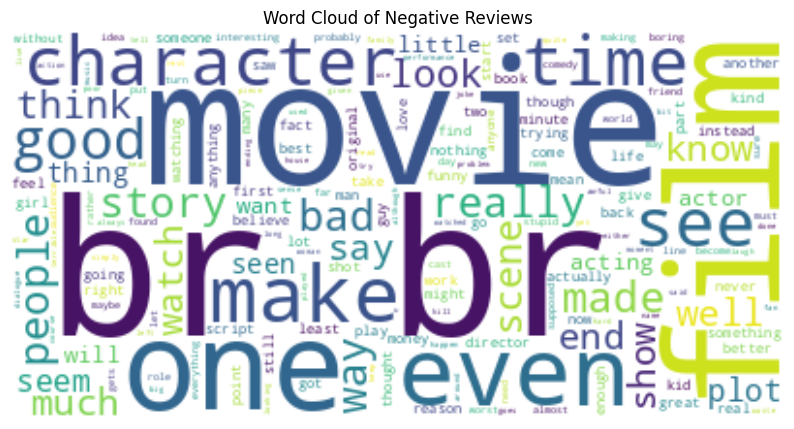

In [ ]:
negative_text = " ".join(review for review in dt[dt["sentiment"]=="negative"].review)
wordcloud_neg = WordCloud(background_color="white").generate(negative_text)

# Set the figure size
plt.figure(figsize=(10, 6))

# Generate the word cloud
plt.imshow(wordcloud_neg, interpolation='bilinear')

# Add a title
plt.title("Word Cloud of Negative Reviews")

# Hide the axis
plt.axis("off")

# Display the plot
plt.show()

##Preprocessing dataset

In [ ]:
# Data preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

dt['processed_review'] = dt['review'].apply(preprocess_text)

##Splitting dataset

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    dt['processed_review'],
    dt['sentiment'],
    test_size=0.2,
    random_state=42
)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# Tokenize and pad sequences
max_words = 10000  # Adjust based on your dataset
max_len = 100      # Adjust based on the desired sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Build CNN-LSTM model
embedding_dim = 100
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
optimizer = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 49, 100)           66000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                        

In [ ]:
# Train the model
batch_size = 32
epochs = 5

model.fit(X_train_pad, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
563/563 [==============================] - 130s 217ms/step - loss: 0.3940 - accuracy: 0.8136 - val_loss: 0.3156 - val_accuracy: 0.8710
Epoch 2/5
563/563 [==============================] - 122s 216ms/step - loss: 0.2125 - accuracy: 0.9206 - val_loss: 0.3202 - val_accuracy: 0.8650
Epoch 3/5
563/563 [==============================] - 119s 211ms/step - loss: 0.1246 - accuracy: 0.9571 - val_loss: 0.3979 - val_accuracy: 0.8545
Epoch 4/5
563/563 [==============================] - 123s 218ms/step - loss: 0.0728 - accuracy: 0.9780 - val_loss: 0.4909 - val_accuracy: 0.8490
Epoch 5/5
563/563 [==============================] - 124s 219ms/step - loss: 0.0544 - accuracy: 0.9833 - val_loss: 0.5375 - val_accuracy: 0.8570


###Prediction on training data

In [ ]:
# Make predictions on the training set
y_pred_train = model.predict(X_train_pad.reshape(-1, max_len))
threshold = 0.5
y_pred_binary_train = (y_pred_train > threshold).astype(int)

625/625 [==============================] - 23s 36ms/step


In [ ]:
# Calculate evaluation metrics
training_x_accuracy = accuracy_score(y_train_encoded, y_pred_binary_train)
print(f"Accuracy: {training_x_accuracy}")

# Calculating the precision of the model on the training data.
training_x_precision = precision_score(y_train_encoded, y_pred_binary_train)
print("Precision: ", training_x_precision)

# Calculating the recall of the model on the training data. Recall(Senstivity) - the ratio of correctly predicted +ive obsevations to all observaions in actual class
training_x_recall = recall_score(y_train_encoded, y_pred_binary_train)
print("Recall: ", training_x_recall)

# Calculating the F1 score of the model on the training data.
training_x_f1 = f1_score(y_train_encoded, y_pred_binary_train)
print("F1 Score: ", training_x_f1)

Accuracy: 0.9806
Precision:  0.981003799240152
Recall:  0.9802197802197802
F1 Score:  0.980611633020188


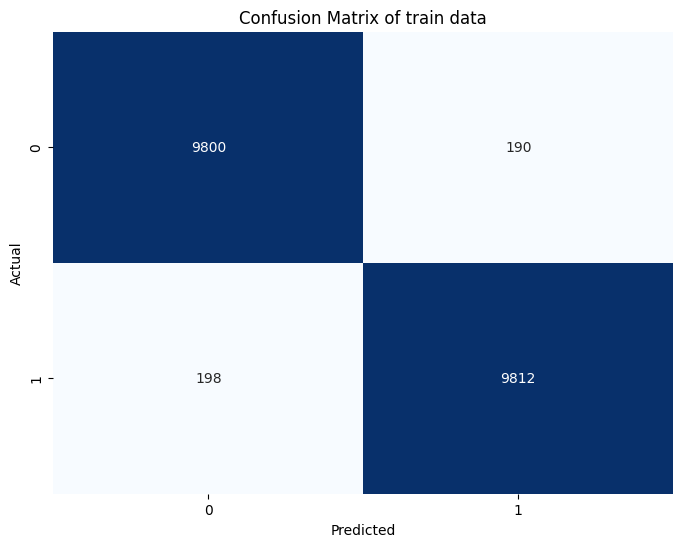

In [ ]:
confusion_mat_train = confusion_matrix(y_train_encoded, y_pred_binary_train)


#create a new figure for the heatmap
plt.figure(figsize=(8, 6))

#plotting the confsion matrix as a heatmap using seaborn
sns.heatmap(confusion_mat_train, annot=True, fmt='d', cmap='Blues', cbar=False)

#setting the labels for the x and y axes
plt.xlabel('Predicted')
plt.ylabel('Actual')

#setting the title for the plot
plt.title('Confusion Matrix of train data')

# Display the plot
plt.show()

In [ ]:
print('Classification Report on Training Data\n', classification_report(y_train_encoded, y_pred_binary_train))

Classification Report on Training Data
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9990
           1       0.98      0.98      0.98     10010

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



###Prediction on testing data

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_pad.reshape(-1, max_len))
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

157/157 [==============================] - 5s 30ms/step


In [ ]:
# Calculate evaluation metrics for test data
testing_x_accuracy = accuracy_score(y_test_encoded, y_pred_binary)
print(f"Accuracy: {testing_x_accuracy}")

# Calculating the precision of the model on the training data.
testing_x_precision = precision_score(y_test_encoded , y_pred_binary)
print("Precision: ", testing_x_precision)

# Calculating the recall of the model on the training data. Recall (Sensiivity) - the ratio of correctly predicted +ive observtions to all observations in actual class
testing_x_recall = recall_score(y_test_encoded, y_pred_binary)
print("Recall: ", testing_x_recall)

# Calculating the F1 score of the model on the training data.
testing_x_f1 = f1_score(y_test_encoded, y_pred_binary)
print("F1 Score: ", testing_x_f1)


Accuracy: 0.8524
Precision:  0.8467933491686461
Recall:  0.8590361445783132
F1 Score:  0.8528708133971292


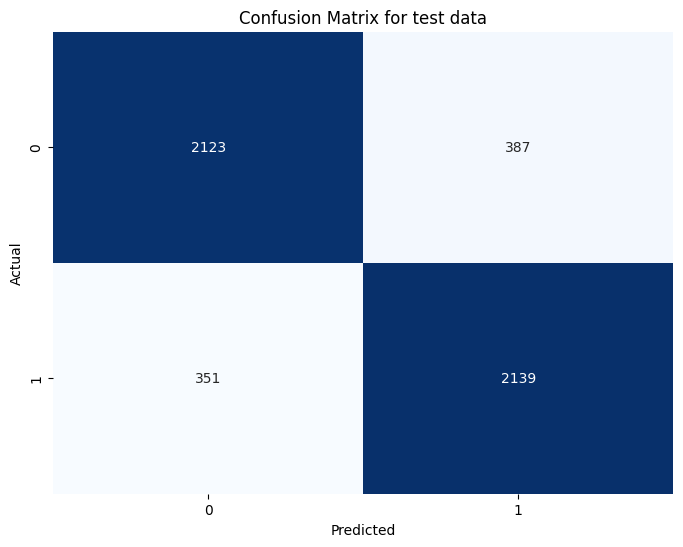

In [ ]:
confusion_mat_test = confusion_matrix(y_test_encoded, y_pred_binary)

#Creating a new figure for the heatmap
plt.figure(figsize=(8, 6))

#plloting the confusion matrix as a heatmap using seaborn
sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Blues', cbar=False)

#setting the labels for the x and y axes
plt.xlabel('Predicted')
plt.ylabel('Actual')

#Seetting the title for the plot
plt.title('Confusion Matrix for test data')

# Display the plot
plt.show()


In [ ]:
class_report = classification_report(y_test_encoded, y_pred_binary)

print(f"Classification report:\n{class_report}")


Classification report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2510
           1       0.85      0.86      0.85      2490

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [ ]:
def preprocess_new_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    return text

def predict_sentiment(model, new_review):
    # Preprocess the new review
    processed_review = preprocess_new_text(new_review)
    # Tokenize and pad the sequence
    sequence = tokenizer.texts_to_sequences([processed_review])
    sequence_padded = pad_sequences(sequence, maxlen=max_len)
    # Predict sentiment
    prediction = model.predict(sequence_padded)[0]
    if prediction >= 0.5:
        return "Positive"
    else:
        return "Negative"

# Example usage:
new_review = "This movie was amazing, I loved every moment of it!"
predicted_sentiment = predict_sentiment(model, new_review)
print("Predicted Sentiment:", predicted_sentiment)


1/1 [==============================] - 0s 65ms/step
Predicted Sentiment: Positive
